In [5]:
import json
from pathlib import Path
import tensorflow as tf
import numpy as np
from PIL import Image
import os
import time
import rasterio as rio
from functools import reduce
from tensorflow.keras.models import load_model

from core.UNet import UNet
from core.losses import (
    tversky,
    accuracy,
    dice_coef,
    dice_loss,
    specificity,
    sensitivity,
)
from core.optimizers import adaDelta

from core.dataset_generator import DataGenerator
from core.split_frames import split_dataset
from core.visualize import display_images

import warnings  # ignore annoying warnings

warnings.filterwarnings("ignore")
import logging

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%reload_ext autoreload
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

print(tf.__version__)

/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adadelta.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adadelta, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)
/usr/local/lib/python3.8/dist-packages/keras/optimizer_v2/adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


2.7.0


In [37]:
from config import UNetTraining as config
from importlib import reload
import core.split_frames as split
import core.frame_info as fram
import core.dataset_generator as dg
# In case you are using a different folder name such as configLargeCluster, then you should import from the respective folder
# Eg. from configLargeCluster import UNetTraining


config = reload(config)
config = config.Configuration()

fram = reload(fram)
split = reload(split)
dg = reload(dg)

In [38]:
# Read all images/frames into memory
frames = []
norm_images = list((config.base_dir/"bands").glob(f"*{config.image_type}"))

for i, image_path in enumerate(norm_images):
        
    norm_img = rio.open(image_path)

    annotation_path = config.base_dir/f"annotation/{image_path.name}"
    
    # Check if the input annotation has detected trees
    with open(annotation_path.with_suffix(".json")) as f:
        trees = len(json.load(f)["Trees"])
        
    if trees:
        annotation_img = Image.open(annotation_path)
        weight_img = Image.open(config.base_dir/f"boundary/{image_path.name}")
        norm_array = norm_img.read()
        norm_array = np.transpose(norm_array, axes=(1,2,0)) #Channel at the end
        annotation_array = np.array(annotation_img)
        weight_array = np.array(weight_img)

        frames.append(
            fram.FrameInfo(
                norm_array, 
                annotation_array, 
                weight_array, 
                image_path.name,
            )
        )

In [39]:
training_frames, validation_frames, testing_frames = split.split_dataset(
    frames, config.frames_json, config.patch_dir
);

Creating and writing train-test split from file
training_frames [3, 4, 2]
validation_frames [1]
testing_frames [0]


In [40]:
# Get frames id
[frame.id for frame in frames]

['2', '2', '12', '1', '10']

In [41]:
# Manually select which are the frames I'd like to test
training_frames = [frames.index(f) for f in frames[-2:]]
validation_frames = [frames.index(frames[1])]
testing_frames  = [frames.index(frames[2])]

In [42]:
config.patch_size

(256, 256, 6)

In [43]:
annotation_channels = config.input_label_channel + config.input_weight_channel
annotation_channels

[4, 5]

In [44]:
annotation_channels = config.input_label_channel + config.input_weight_channel
train_generator = dg.DataGenerator(
    config.input_image_channel,
    config.patch_size,
    training_frames,
    frames,
    annotation_channels,
    augmenter="iaa",
).random_generator(config.BATCH_SIZE, normalize=config.normalize)
# training_frames = validation_frames = testing_frames  = list(range(len(frames)))


In [45]:
val_generator = dg.DataGenerator(
    config.input_image_channel,
    config.patch_size,
    validation_frames,
    frames,
    annotation_channels,
    augmenter=None,
).random_generator(config.BATCH_SIZE, normalize=config.normalize)

In [46]:
test_generator = dg.DataGenerator(
    config.input_image_channel,
    config.patch_size,
    testing_frames,
    frames,
    annotation_channels,
    augmenter=None,
).random_generator(config.BATCH_SIZE, normalize=config.normalize)

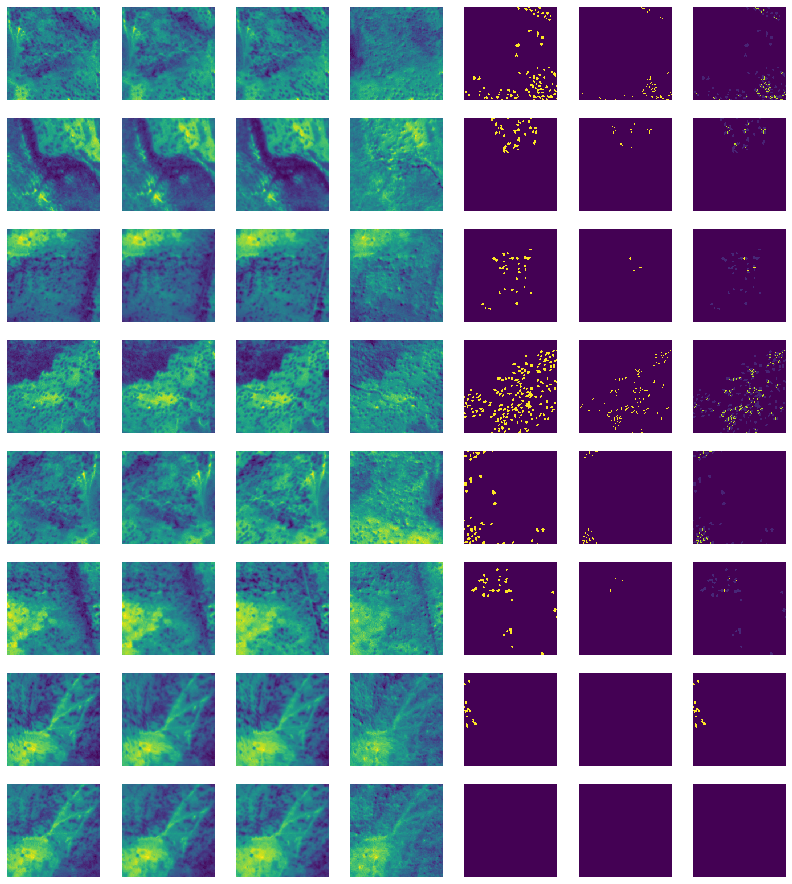

In [47]:
for _ in range(1):
    train_images, real_label = next(train_generator)
    ann = real_label[:, :, :, 0]
    wei = real_label[:, :, :, 1]
    # overlay of annotation with boundary to check the accuracy
    # 5 images in each row are: pan, ndvi, annotation, weight(boundary), overlay of annotation with weight
    overlay = ann + wei
    overlay = overlay[:, :, :, np.newaxis]
    display_images(np.concatenate((train_images, real_label, overlay), axis=-1))

In [48]:
OPTIMIZER = adaDelta
LOSS = tversky

# Only for the name of the model in the very end
OPTIMIZER_NAME = "AdaDelta"
LOSS_NAME = "weightmap_tversky"

# Declare the path to the final model
# If you want to retrain an exising model then change the cell where model is declared.
# This path is for storing a model after training.

timestr = time.strftime("%Y%m%d-%H%M")
chf = config.input_image_channel + config.input_label_channel
chs = reduce(lambda a, b: a + str(b), chf, "")


if not os.path.exists(config.model_path):
    os.makedirs(config.model_path)
model_path = os.path.join(
    config.model_path,
    "trees_{}_{}_{}_{}_{}.h5".format(
        timestr, OPTIMIZER_NAME, LOSS_NAME, chs, config.input_shape[0]
    ),
)

# The weights without the model architecture can also be saved. Just saving the weights is more efficent.

# weight_path="./saved_weights/UNet/{}/".format(timestr)
# if not os.path.exists(weight_path):
#     os.makedirs(weight_path)
# weight_path=weight_path + "{}_weights.best.hdf5".format('UNet_model')
# print(weight_path)

In [49]:
# Define the model and compile it
model = UNet([config.BATCH_SIZE, *config.input_shape], config.input_label_channel)
model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=[dice_coef, dice_loss, specificity, sensitivity, accuracy],
)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 64  2368        ['Input[0][0]']                  
                                )                                                                 
                                                                                                  
 conv2d_20 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_19[0][0]']              
                                )                                                           

In [50]:
# Define callbacks for the early stopping of training, LearningRateScheduler and model checkpointing
from tensorflow.keras.callbacks import (
    ModelCheckpoint,
    LearningRateScheduler,
    EarlyStopping,
    ReduceLROnPlateau,
    TensorBoard,
)


checkpoint = ModelCheckpoint(
    model_path,
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    mode="min",
    save_weights_only=False,
)

# reduceonplatea; It can be useful when using adam as optimizer
# Reduce learning rate when a metric has stopped improving (after some patience,reduce by a factor of 0.33, new_lr = lr * factor).
# cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.33,
    patience=4,
    verbose=1,
    mode="min",
    min_delta=0.0001,
    cooldown=4,
    min_lr=1e-16,
)

# early = EarlyStopping(monitor="val_loss", mode="min", verbose=2, patience=15)

log_dir = os.path.join(
    "./logs",
    "UNet_{}_{}_{}_{}_{}".format(
        timestr, OPTIMIZER_NAME, LOSS_NAME, chs, config.input_shape[0]
    ),
)
tensorboard = TensorBoard(
    log_dir=log_dir,
    histogram_freq=0,
    write_graph=True,
    write_grads=False,
    write_images=False,
    embeddings_freq=0,
    embeddings_layer_names=None,
    embeddings_metadata=None,
    embeddings_data=None,
    update_freq="epoch",
)

callbacks_list = [
    checkpoint,
    tensorboard,
]  # reduceLROnPlat is not required with adaDelta

In [ ]:
loss_history = [
    model.fit(
        train_generator,
        steps_per_epoch=config.MAX_TRAIN_STEPS,
        epochs=config.NB_EPOCHS,
        validation_data=val_generator,
        validation_steps=config.VALID_IMG_COUNT,
        callbacks=callbacks_list,
        workers=4,
        use_multiprocessing=True
        #                         use_multiprocessing=True # the generator is not very thread safe
    )
]

Epoch 1/200
1000/1000 [==============================] - ETA: 0s - loss: 0.3368 - dice_coef: 0.9306 - dice_loss: 0.0694 - specificity: 0.9901 - sensitivity: 0.6395 - accuracy: 0.9787
Epoch 00001: val_loss improved from inf to 1.00023, saving model to ./saved_models/UNet/trees_20220525-1637_AdaDelta_weightmap_tversky_01234_256.h5
1000/1000 [==============================] - 587s 573ms/step - loss: 0.3368 - dice_coef: 0.9306 - dice_loss: 0.0694 - specificity: 0.9901 - sensitivity: 0.6395 - accuracy: 0.9787 - val_loss: 1.0002 - val_dice_coef: 0.9987 - val_dice_loss: 0.0013 - val_specificity: 1.0000 - val_sensitivity: nan - val_accuracy: 0.9987
Epoch 2/200
1000/1000 [==============================] - ETA: 0s - loss: 0.1838 - dice_coef: 0.9841 - dice_loss: 0.0159 - specificity: 0.9961 - sensitivity: 0.7782 - accuracy: 0.9890
Epoch 00002: val_loss did not improve from 1.00023
1000/1000 [==============================] - 567s 567ms/step - loss: 0.1838 - dice_coef: 0.9841 - dice_loss: 0.0159 -

# Test model

In [14]:
models = list(Path(model_path).parent.glob("*.h5"))
models

[PosixPath('saved_models/UNet/trees_20220525-0839_AdaDelta_weightmap_tversky_01234_256.h5'),
 PosixPath('saved_models/UNet/trees_20220525-1339_AdaDelta_weightmap_tversky_01234_256.h5')]

In [15]:
# Load model after training
# If you load a model with different python version, than you may run into a problem: 
# https://github.com/keras-team/keras/issues/9595#issue-303471777

model = load_model(
    models[-1],
    custom_objects={
        "tversky": LOSS,
        "dice_coef": dice_coef,
        "dice_loss": dice_loss,
        "accuracy": accuracy,
        "specificity": specificity,
        "sensitivity": sensitivity,
    },
    compile=False,
)

2022-05-25 15:34:44.994715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 15:34:45.103235: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 15:34:45.103906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-25 15:34:45.105855: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:

# In case you want to use multiple GPU you can uncomment the following lines.
# from tensorflow.python.keras.utils import multi_gpu_model
# model = multi_gpu_model(model, gpus=2, cpu_merge=False)

model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=["dice_coef", "dice_loss", "accuracy", "specificity", "sensitivity"],
)

2022-05-25 15:34:58.490391: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204
2022-05-25 15:35:00.237143: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


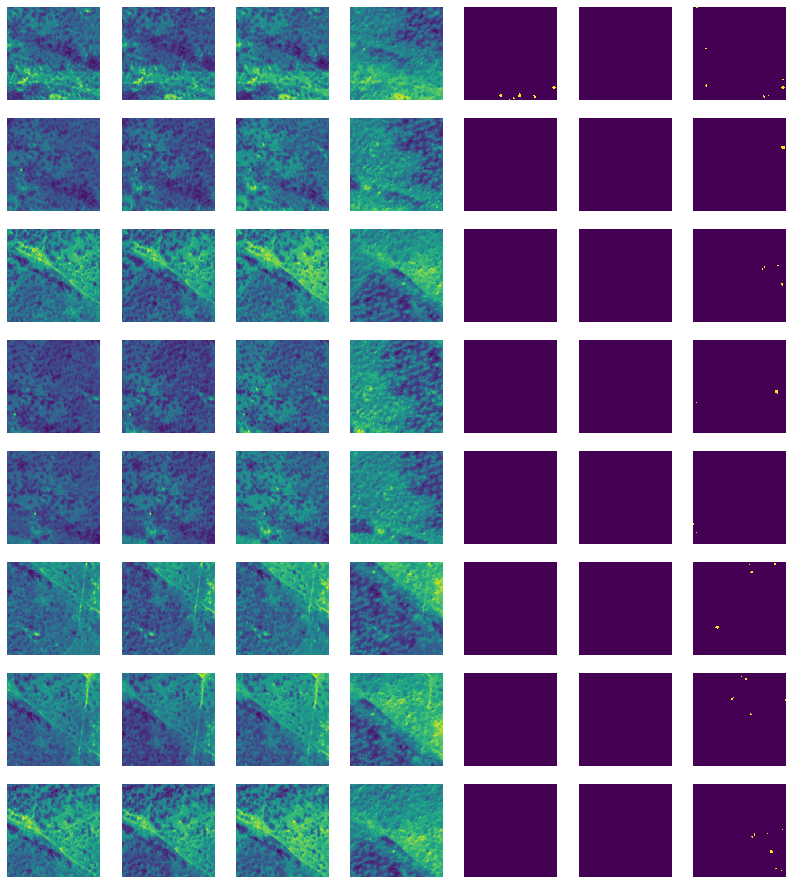

In [17]:
# Print one batch on the training/test data!
for i in range(1):
    test_images, real_label = next(test_generator)
    prediction = model.predict(test_images, steps=1)
    prediction[prediction > 0.5] = 1
    prediction[prediction <= 0.5] = 0
    display_images(np.concatenate((test_images, real_label, prediction), axis=-1))

In [19]:
prediction.shape

(8, 256, 256, 1)

In [23]:
prediction[1, ...].shape

(256, 256, 1)

# Open the first prediction

In [28]:
from pathlib import Path

In [32]:
norm_images = list((config.base_dir/"bands").glob(f"*{config.image_type}"))
image_path = norm_images[0]
norm_img = rio.open(image_path)
profile = norm_img.profile
profile.update({
    "width":256,
    "height":256,
    "count":8,
})
profile

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 0.0, 'width': 256, 'height': 256, 'count': 8, 'crs': CRS.from_epsg(32629), 'transform': Affine(3.0, 0.0, 813894.0,
       0.0, -3.0, 1315152.0), 'blockxsize': 32, 'blockysize': 32, 'tiled': True, 'compress': 'lzw', 'interleave': 'pixel'}

In [42]:
with rio.open("test/prediction.tif", "w", **profile) as dst:
    for band in list(range(8)):
        
        array = prediction[band, ...]
        array = np.transpose(array, axes = (2,1,0))
        print(array.shape)
        dst.write(array.astype(profile["dtype"]), band+1)

(1, 256, 256)


ValueError: Source shape (1, 1, 256, 256) is inconsistent with given indexes 1